###資料前處理

In [742]:
%cd D:\研究所\論文研究\新生兒

D:\研究所\論文研究\新生兒


In [743]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import tensorflow as tf
import copy
from torch.autograd import Variable
import torch.optim as optim
import time
import math

In [744]:
data_df = pd.read_csv("birthweight_test.csv")
data_df["AGE"] = np.log(data_df["AGE"])
data_df["lwt"] = np.log(data_df["lwt"])
data_df.dropna(inplace=True)

In [745]:
def NOT_duplicate(df):
    print(f'資料總數:{len(df)}')
    a = df.duplicated(keep='first', subset = df.columns[:-1])#'first' #X相同, y相同or不同，都刪除
    count = 0
    for i in range(len(a)):
        if a[i] == True:
            count += 1
    print(f'-----------------共有{count}筆完全重複資料-----------------')
    df = df.drop_duplicates(keep='first', subset = df.columns[:-1])
    print('已刪除重複資料')
    print(f'資料總數:{len(df)}')
    return df
data_df = NOT_duplicate(data_df)

資料總數:189
-----------------共有7筆完全重複資料-----------------
已刪除重複資料
資料總數:182


In [746]:
def check_duplicate(df):
    print(f'重複資料的index: ')
    for i in range(len(data_df)):
        for j in range(len(data_df)):
            if np.array_equal(data_df.iloc[i].values, data_df.iloc[j].values) and i != j:
                print(i)

#check_duplicate(data_df)

In [747]:
#data_df['bwt'].values < 2500
lbw = np.zeros_like(data_df['bwt'].values)
lbw = [-1 if bwt <2500 else 1 for bwt in data_df['bwt'].values]
data_df['lbw'] = lbw

In [748]:
data_df

,AGE,lwt,race,smoke,ptl,ht,ui,bwt,lbw
0,2.944439,5.204007,2.0,0.0,0.0,0.0,1.0,2523.0,1
1,3.496508,5.043425,3.0,0.0,0.0,0.0,0.0,2551.0,1
2,2.995732,4.653960,1.0,1.0,0.0,0.0,0.0,2557.0,1
3,3.044522,4.682131,1.0,1.0,0.0,0.0,1.0,2594.0,1
4,2.890372,4.672829,1.0,1.0,0.0,0.0,1.0,2600.0,1
...,...,...,...,...,...,...,...,...,...
184,3.332205,4.553877,1.0,1.0,0.0,0.0,0.0,2466.0,-1
185,2.639057,4.605170,3.0,0.0,0.0,0.0,0.0,2495.0,-1
186,3.135494,4.543295,3.0,1.0,0.0,0.0,0.0,2495.0,-1
187,2.833213,4.955827,2.0,0.0,0.0,1.0,0.0,2495.0,-1


In [749]:
data_df['bwt'].describe()
threshold_for_infer = (2500 - data_df['bwt'].mean())/data_df['bwt'].std() #-0.5879256744378174

In [750]:
data_df['bwt'] = (data_df['bwt']-data_df['bwt'].mean())/data_df['bwt'].std()

In [751]:
data_df

,AGE,lwt,race,smoke,ptl,ht,ui,bwt,lbw
0,2.944439,5.204007,2.0,0.0,0.0,0.0,1.0,-0.554575,1
1,3.496508,5.043425,3.0,0.0,0.0,0.0,0.0,-0.516773,1
2,2.995732,4.653960,1.0,1.0,0.0,0.0,0.0,-0.508673,1
3,3.044522,4.682131,1.0,1.0,0.0,0.0,1.0,-0.458720,1
4,2.890372,4.672829,1.0,1.0,0.0,0.0,1.0,-0.450620,1
...,...,...,...,...,...,...,...,...,...
184,3.332205,4.553877,1.0,1.0,0.0,0.0,0.0,-0.631529,-1
185,2.639057,4.605170,3.0,0.0,0.0,0.0,0.0,-0.592377,-1
186,3.135494,4.543295,3.0,1.0,0.0,0.0,0.0,-0.592377,-1
187,2.833213,4.955827,2.0,0.0,0.0,1.0,0.0,-0.592377,-1


In [752]:
x = data_df.iloc[:,:-1]
y = data_df.iloc[:,-1]
x = x.to_numpy()
y = y.to_numpy()

In [753]:
def data_oversampling(x,y):

    print("初始資料分布")

    cnt_0, cnt_1= 0,0
    for label in y:
        if label == -1:
            cnt_0 += 1
        elif label == 1:
            cnt_1 += 1
    print(f'-1類別筆數 = {cnt_0}\n1類別筆數 = {cnt_1}\n')

    smote = SMOTE(random_state = 11)
    x, y = smote.fit_resample(x, y) 

    cnt_0, cnt_1= 0,0
    for label in y:
        if label == -1:
            cnt_0 += 1
        elif label == 1:
            cnt_1 += 1
    print("After Oversampling")
    print(f'-1類別筆數 = {cnt_0}\n1類別筆數 = {cnt_1}\n')
  

    return x, y
x, y = data_oversampling(x, y)

初始資料分布
-1類別筆數 = 59
1類別筆數 = 123

After Oversampling
-1類別筆數 = 123
1類別筆數 = 123



In [754]:
def class_inspection(x,y):
    print("資料分布")

    cnt_0, cnt_1= 0,0
    for label in y:
        if label == -1:
            cnt_0 += 1
        elif label == 1:
            cnt_1 += 1
    print(f'-1類別筆數 = {cnt_0}\n1類別筆數 = {cnt_1}\n')

In [755]:
#smote的關係，必須讓label(y)作為一個參數作oversampling。我認為可以把label也當作x之一，y仍為bwt
#考慮到實驗公平性，我先不把lbw列入欄位
# y = x[:,-1]
# x = x[:,:-1]

### CSI(新生兒)

In [756]:
class Network(torch.nn.Module):
    def __init__(self, x_train_scaled, nb_neuro, y_train_scaled):
        super(Network, self).__init__() 
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro)
        self.linear2 = torch.nn.Linear(nb_neuro, y_train_scaled.shape[1])
        #self.dropout = torch.nn.Dropout(0.3)
        # Stop criteria - threshold
        self.threshold_for_error = 0.7
        self.threshold_for_lr = 1e-5 
        
        # Input data
        self.x = torch.FloatTensor(x_train_scaled)
        self.y = torch.FloatTensor(y_train_scaled)
        # Whether the network is acceptable
        self.acceptable = False
        # Learning rate
        self.learning_rate = 1e-3 #Change itself to enlarge or shrink
        self.learning_rate_initial = 1e-3 #To initialize the learning_rate after changing
        

    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled)
        self.y = torch.FloatTensor(y_train_scaled)
        
    def addData(self, new_x_train, new_y_train):
        self.x = torch.FloatTensor(new_x_train[0])
        self.y = torch.FloatTensor(new_y_train[0])
    
        # forward operation
    def forward(self, reg_t=0):
        
        #h_relu = self.linear1(self.x).clamp(min=0) + 1e-2 * self.linear1(self.x).clamp(max=0) #Leaky Relu
        h_relu = self.linear1(self.x).clamp(min=0) #Relu
        yo = self.linear2(h_relu)
        reg_term= reg_t/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +   (self.linear2.weight.data.shape[1]*(self.linear1.weight.data.shape[1]+1)))*(torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2)))
        loss = torch.nn.functional.mse_loss(yo,self.y) + reg_term
        return (yo,loss)


    # backward operation #https://discuss.pytorch.org/t/what-step-backward-and-zero-grad-do/33301
    def backward_Adam(self,loss):    
        optimizer = optim.Adam(network.parameters(), lr=self.learning_rate, weight_decay=0.1) #优化函数，model.parameters()为该实例中可优化的参数，lr为参数优化的选项（学习率等）
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def backward_Adadelta(self,loss):
        optimizer =optim.Adadelta(network.parameters(), lr=self.learning_rate,rho=0.9, eps=1e-06, weight_decay=1) #weight_decay = 0
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def backward_RMSprop(self,loss):
        optimizer = optim.RMSprop(network.parameters(), lr = self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def backward_Adagrad(self,loss):
        optimizer = optim.Adagrad(network.parameters(), lr = self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def backward_AMSgrad(self,loss):
        optimizer = optim.AdamW(network.parameters(), lr = self.learning_rate,amsgrad=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [757]:
def initializing(network, initial_x, initial_y):
    print("<<  Initializing Start  >>")
    initial_x=torch.FloatTensor(initial_x)
    initial_y=torch.FloatTensor(initial_y)
    min_y = min(initial_y)    
    res_y = initial_y-min_y
    reg = LinearRegression().fit(initial_x, res_y)

    network.linear1.weight.data = Variable(torch.FloatTensor(reg.coef_))
    network.linear1.bias.data = Variable(torch.FloatTensor(reg.intercept_))
    network.linear2.weight.data = Variable(torch.ones(1,1))
    network.linear2.bias.data = Variable(min_y)
    #print(f'linear2.bias : {network.linear2.bias.data}')
    
    network.acceptable =True
    print(f'network.linear1 的 權重 : {network.linear1.weight.data}\n')
    print(f'network.linear1 的 偏差值 : {network.linear1.bias.data}\n')
    print(f'network.linear2 的 權重 : {network.linear2.weight.data}\n')
    print(f'network.linear2 的 偏差值 : {network.linear2.bias.data}\n')
    print("<<  Initializing End  >>")

In [758]:
def selecting(network, x_train_scaled, y_train_scaled):   #把全部資料一筆一筆跑進來，依照error值由小到大排列，從最小的開始訓練
    print("<<  Selecting Start  >>")
    print(" ------------------------------")
    residual = []
    train_x=torch.randn(1,7)
    train_y=torch.randn(1,1)
    temp_network = copy.deepcopy(network)
    for i in range(x_train_scaled.shape[0]):
        train_x=torch.FloatTensor(x_train_scaled[i])
        train_y=torch.FloatTensor(y_train_scaled[i])
        temp_network.x=train_x
        temp_network.y=train_y
        residual_calculate=temp_network.forward()[1].item()
        #print(residual_calculate)
        residual.append(residual_calculate)
    min_residual = min(residual)
    print(" Min Loss selected for this round : %f"%min_residual)
#     print(min_loss)
    min_residual_index = residual.index(min_residual)
    print(" ------------------------------")
    print("<<  Selecting End  >>\n")
    return (x_train_scaled[min_residual_index],y_train_scaled[min_residual_index],min_residual_index)
    

In [759]:
def matching(network):
#     matching_count = 0  #calculate matching 
    print("<<  Matching Start  >>")
    print(" ------------------------------")
    network.learning_rate = network.learning_rate_initial
    print(f'learning_rate = {network.learning_rate}')
    
    while True:
        
        yo, loss = network.forward()
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):   #learning goal直接過，進regularizing
            #print("Learning goal : %f <= %f " %(torch.abs(yo-network.y),network.threshold_for_error))
            network.acceptable = True
            print("Matching finished - the network is acceptable")
#             matching_count += 1
            print(" ------------------------------")
            print("<<  Matching Completed  >>\n")
            return (network)

        else:                                                       #learning goal沒過，進matching，調整weight
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            network.backward_Adam(loss)
            yo, loss = network.forward()

            #調整完的loss是否變小，作為model是否調整好的依據
            if loss < loss_pre: #因為到了local minimum，所以導致loss = loss_pre，就會一直卡在這個部分，導致最後learning_rate過大，程式無法計算                        
                #print("Loss: %f < %f , learning rate: %f, tuning the learning rate more bigger." %(loss,loss_pre,network.learning_rate))
                network.learning_rate *= 1.2

            else:
                network = network_pre
                if network.learning_rate <= network.threshold_for_lr:  #看learning rate是否變太小
                    #print("Loss: %f <= %f , learning rate: %f, Oops!!! Learning rate is tooooo SMALL." %(loss,loss_pre,network.learning_rate))
                    print("Matching finished - the network is Unacceptable  ")
                    print("Restore the network  ")
                    print(" ------------------------------")
                    print("<<  Matching Failed  >>\n")
                    network.acceptable = False
                    return (network)

                else:                                                 #learning rate還沒變太小，可以繼續調整
                    #print("Loss: %f <= %f , learning rate: %f, tuning the learning rate more smaller." %(loss,loss_pre,network.learning_rate))
                    network.learning_rate *= 0.7

In [760]:
def re_matching(network):
    print("<<  Matching Start (Reorganizing)  >>")
    print(" ------------------------------")
    network.learning_rate = network.learning_rate_initial
    print(f'learning_rate = {network.learning_rate}')

    while True:
        
        yo, loss = network.forward()
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):    #沒問題
            network.acceptable = True
            print("Matching (Reorganizing) finished - the network is acceptable")
            print(" ------------------------------")
            print("<<  Matching Completed (Reorganizing) >>\n")
            return (network)

        else:                #沒問題                                             
            
            network_pre = copy.deepcopy(network)
            loss_pre = loss
            
            network.backward_Adam(loss)

            yo, loss = network.forward()

            if loss < loss_pre: #因為到了local minimum，所以導致loss = loss_pre，就會一直卡在這個部分，導致最後learning_rate過大，程式無法計算
                #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, tuning the learning rate more bigger.")
                network.learning_rate *= 1.2

            else:

                network = network_pre

                if network.learning_rate <= network.threshold_for_lr:     #看learning rate是否變太小
                    #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, Oops!!! Learning rate is tooooo SMALL.")
                    print("Matching (Reorganizing) finished - the network is Unacceptable")
                    print("Restore the network  ")
                    print(" ------------------------------")
                    print("<<  Matching Failed (Reorganizing) >>\n")
                    network.acceptable = False
                    return (network)

                else:                                                   #learning rate還沒變太小，可以繼續調整

                    #print(f"Loss: {loss} < {loss_pre}, learning rate: {network.learning_rate}, tuning the learning rate more smaller.")
                    network.learning_rate *= 0.7

In [761]:
def regularizing(network):

    
    #network.learning_rate = 1e-1           #regularizing的learning rate
    print("<<  Regularizing Start  >>")
    print(" ------------------------------")
    network.learning_rate = network.learning_rate_initial
    print(f'learning_rate = {network.learning_rate}')

    for i in range(1,501):                                   #只做100次

        network_pre = copy.deepcopy(network)
        yo, loss= network.forward(1e-3)    #1e-3                  #加入regularizing term
        loss_pre = loss 
        network.backward_Adam(loss)

        #print(f'目前權重 : {network.state_dict()}\n')
        #time.sleep(0.001)

        yo, loss= network.forward(1e-3)    #1e-3 

        if loss <= loss_pre:       #<=                          #比較loss
            if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):  #比較learning goal
                network.learning_rate *= 1.2
                if i % 50 == 0 : print("The Regularizing process: %d"%i) 
                # print(f"Learning goal : {torch.abs(yo-network.y)} <= {network.threshold_for_error}, OK! you can keep tuning the learning rate")
                # print(f"Loss: {loss} <= {loss_pre} , learning rate: {network.learning_rate}, tuning the learning rate more bigger.")
                if (i == 500):
                    print(" ------------------------------")
                    print("<<  Regularizing End  >>")
                    return (network)

            else:                                            #learning goal不符合，regularizing end
                network = network_pre
                #print(f"Learning goal : {torch.abs(yo-network.y)} > {network.threshold_for_error}")
                print("Regularizing finished(A): Learning goal exceeds the standard.")
                print(" ------------------------------")
                print("<<  Regularizing Failed  >>")
                return (network)
        else:
            network = network_pre
            
            if network.learning_rate > network.threshold_for_lr:
                #print(f"Loss: {loss} > {loss_pre} , learning rate: {network.learning_rate}, tuning the learning rate more smaller.")
                network.learning_rate *= 0.7

            else:
                #print(f"Loss: {loss} > {loss_pre} , learning rate: {network.learning_rate}, Oops!!! Learning rate is tooooo SMALL.")
                print("Regularizing finished(B) : learning rate is toooooo small")
                print(" ------------------------------")
                print("<<  Regularizing Failed  >>")
                return (network)

        


In [762]:
def reorganizing(network):   

    time_sucess = 0
    k = 1
    p = network.linear1.weight.data.shape[0]
    
    print("<<  Reorganizing Start  >>")
    print(" --------------------------------------------------")
    while True:                                 #每顆hidden node都抓出來檢查
        if k > p:                            

            print("The number of neuro: ",p)
            print("\n")
            print(f"(內)time_sucess = {time_sucess}")

            return (network, time_sucess)

        else:

            network = regularizing(network)

            #display(type(network))

            network_pre = copy.deepcopy(network) #此處copy的是做完Regularizing後，符合learning goal的net

            network.acceptable = False      #delete kth hidden node and do matching

            network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]]))
            network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1], network.linear1.bias[k:]]))
            network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1], network.linear2.weight[:,k:]],1))

            network = re_matching(network) #Matching失敗是正常的狀況，本來就會有成功(A)與失敗(B)的兩條路徑。


            if (network.acceptable==True) and (p!=1):    #過learning goal and hidden node數量 > 1，刪除此顆hidden node
                time_sucess += 1
                print("You need to drop out the nero number: %d / %d\n" %(k, p))
                p-=1

            else:                                  #沒過learning goal，此顆node不刪除
                network = network_pre
                print("Cannot drop out the nero number: %d / %d\n" %(k, p))
                print("\n")
                k+=1

    
#     reorganizing_count += 1
    print(" --------------------------------------------------")
    print("<<  Reorganizing End  >>\n")


In [763]:
def cramming(network,Xc):
    Xc = Xc[:-1]
    Xc = torch.FloatTensor(Xc)
    Xk = network.x[-1] #good
    yo, loss = network.forward()
    k_data_num = len(Xc)

    print("<<  Cramming Start  >>")
    print(" ------------------------------")
    count_gamma = 0
    count_zeta = 0
    


    while True:
        ## Find m-vector gamma: r
        gamma = torch.rand(size=[1,network.x.shape[1]])
        #print(f'Xc = {Xc}\nXk = {Xk}\n')
        subtract_undesired_data = torch.subtract(Xc, Xk)
        matmul_value = torch.matmul(gamma,torch.t(subtract_undesired_data))
        # if 0 not in matmul_value:
        #     break
        if torch.all(matmul_value != 0):
            break
    while True:               ## Find the tiny value: zeta
        zeta = torch.rand(size=[1])
        if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
            break

    w10 = gamma
    w11 = gamma
    w12 = gamma

    W1_new = torch.cat([w10,w11,w12],0) #Hidden layer的weight
    matual_value = torch.matmul(gamma, torch.t(Xk))


    b10 = torch.subtract(zeta,matual_value)
    b11 = -1*matual_value
    b12 = torch.subtract(-1*zeta,matual_value)
    
    b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3]) #Hidden layer的bias
    #print(f'b10 = {b10}\nb11 = {b11}\nb12 = {b12}\n')
    #print(f'torch.reshape(torch.cat([b10,b11,b12],0) = \n {torch.cat([b10,b11,b12],0)} \n')
    #print(f'b1_new = {b1_new}')
    #time.sleep(5)
    
    #network.y = Yk
    gap = network.y[-1] - yo[-1] 
    gap = float(gap)
    wo0_value = gap/zeta
    wo1_value = (-2*gap)/zeta
    wo2_value = gap/zeta
    


    #Wo_new=torch.cat((wo0_value,wo1_value,wo2_value),1)
    Wo_new = torch.cat((wo0_value,wo1_value,wo2_value),0)
    Wo_new = torch.unsqueeze(Wo_new, 0)
    #print(f'network.y = {network.y}\nyo = {yo}\ngap = {gap}\nzeta = {zeta}')
    #print(f'wo0 = {wo0_value}\nwo1 = {wo1_value}\nwo2 = {wo2_value}\nWo_new = {Wo_new}')
    network.linear1.weight.data = Variable(torch.cat([network.linear1.weight.data, W1_new]))
    #print(network.linear1.weight.data)
    #time.sleep(10)
    network.linear1.bias.data = Variable(torch.cat([network.linear1.bias.data, b1_new]))
    #print(network.linear1.bias.data)
    #print(f'network.linear2.weight.data.shape = {network.linear2.weight.data.shape}\nWo_new.shape = {Wo_new.shape}')
    network.linear2.weight.data = Variable(torch.cat([network.linear2.weight.data, Wo_new],1))
    
    network.acceptable = True
    print("Cramming success!")

    print(" ------------------------------")
    print("<<  Cramming End  >>\n")
    return network

In [764]:
def test(network, x_test, y_test):   #把全部資料一筆一筆跑進來，依照error值由小到大排列，從最小的開始訓練
    print("<<  Test Start  >>")
    print(" ------------------------------")
    check = []
    test_x=torch.randn(1, 7) #X屬性數量變動要更正
    test_y=torch.randn(1,1)
    temp_network = copy.deepcopy(network)
    for i in range(x_test.shape[0]):
        test_x=torch.FloatTensor(x_test[i])
        test_y=torch.FloatTensor(y_test[i])
        temp_network.x=test_x
        temp_network.y=test_y
        yot=temp_network.forward()[0].item()
        
        check.append((yot, y_test[i])) 
    print(" ------------------------------")
    print("<<  Test End  >>\n")
    return check

In [765]:
def accuracy(check):
    count = 0
    for yo in check:
        if yo[0] < threshold_for_infer and yo[1] < threshold_for_infer:
            count += 1
        if yo[0] >= threshold_for_infer and yo[1] >= threshold_for_infer:
            count += 1
    accuracy = count / len(check)
    return accuracy

In [766]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def make_confusion_matrix(check):
    
    y_pred = [1 if yo[0] < threshold_for_infer else -1  for yo in check]
    y_true = [1 if yo[1] < threshold_for_infer else -1  for yo in check]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1,1])
    disp.plot()

    return cm

In [767]:
def make_indicator(cm):

    matrix_indicator = {}
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

    TPR = tp / (tp+fn)
    TNR = tn / (tn+fp)
    PPV = tp / (tp+fp)
    NPV = tn / (tn+fn)
    FNR = fn / (fn+tp)
    FPR = fp / (fp+tn)
    FDR = fp / (fp+tp)
    FOR = fn / (fn+tn)
    F1 = 2*tp / (2*tp+fp+fn)
    
    matrix_indicator['TPR'] = TPR
    matrix_indicator['TNR'] = TNR
    matrix_indicator['PPV'] = PPV
    matrix_indicator['NPV'] = NPV
    matrix_indicator['FNR'] = FNR
    matrix_indicator['FPR'] = FPR
    matrix_indicator['FDR'] = FDR
    matrix_indicator['FOR'] = FOR
    matrix_indicator['F1'] = F1

    return matrix_indicator

In [768]:
def check_spliting(check):
    y_pred = []
    y_real = []
    for element in check:
        y_pred.append(element[0])
        y_real.append(element[1])

    y_label = [1 if e < threshold_for_infer else -1  for e in y_real]
    return y_pred, y_real, y_label

## 主程式

In [769]:
k_fold = 3

###Set no.1

####Train Test Split & Cross Validation

In [770]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=69)

In [771]:
#檢查類別比例
class_inspection(x_train,y_train)
class_inspection(x_test,y_test)

資料分布
-1類別筆數 = 86
1類別筆數 = 86

資料分布
-1類別筆數 = 37
1類別筆數 = 37



In [772]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=None) 
skf.get_n_splits(x_train, y_train) #check n_splits

data_cv = []

for train_index, val_index in skf.split(x_train, y_train):
    #print("\nTRAIN:", train_index, "\nVAL:", val_index)
    x_val, x_train_ = x_train[val_index], x_train[train_index]
    y_val, y_train_ = y_train[val_index], y_train[train_index]

    
    data_cv.append([x_train_, x_val, y_train_, y_val])



In [773]:
#k_fold = 2 #0~4
 #x_train, x_val, y_train, y_val
x_train = data_cv[k_fold][0]
x_val = data_cv[k_fold][1]
y_train = data_cv[k_fold][2]
y_val = data_cv[k_fold][3]

In [774]:
len(x_train)

138

####Initializing

In [775]:
# y = x[:,-1]
# x = x[:,:-1]

y_train, y_val, y_test = x_train[:,-1], x_val[:,-1], x_test[:,-1]
x_train, x_val, x_test = x_train[:,:-1], x_val[:,:-1], x_test[:,:-1] 

In [776]:
def floor(x_train, x_val, x_test): #用Oversampling，資料中的類別屬性會出現連續數值，因此math.floor(x)處理

    for row in x_train:
        for i in range(2,7):
            row[i] = math.floor(row[i])
    for row in x_val:
        for i in range(2,7):
            row[i] = math.floor(row[i])
    for row in x_test:
        for i in range(2,7):
            row[i] = math.floor(row[i])

floor(x_train, x_val, x_test)

In [777]:

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

initial_x = x_train[:x_train.shape[1]+1]
initial_y = y_train[:x_train.shape[1]+1]

print(f'initial_x.shape : {initial_x.shape}')
print(f'initial_y.shape : {initial_y.shape}\n')

x_train_scaled = x_train[x_train.shape[1]+1:]
y_train_scaled = y_train[x_train.shape[1]+1:]

print(f'x_train_scaled.shape : {x_train_scaled.shape}')
print(f'y_train_scaled.shape : {y_train_scaled.shape}\n')

network = Network(initial_x, 1, initial_y)
initializing(network, initial_x, initial_y)

train_time=x_train_scaled.shape[0]
#print(type(x_train_scaled ))


initial_x.shape : (8, 7)
initial_y.shape : (8, 1)

x_train_scaled.shape : (130, 7)
y_train_scaled.shape : (130, 1)

<<  Initializing Start  >>
network.linear1 的 權重 : tensor([[-0.8651,  1.0617, -0.8151, -1.6704,  1.1126,  0.0000, -0.1252]])

network.linear1 的 偏差值 : tensor([0.8507])

network.linear2 的 權重 : tensor([[1.]])

network.linear2 的 偏差值 : tensor([-2.2084])

<<  Initializing End  >>


####統計數據初始化

In [778]:
num_hiddennodes = {}
reorganizing_sucess = {}
timestamp = []
count_module = {}
count_module['matching'], count_module['reorganizing'], count_module['cramming'] = 0,0,0
percentage_route = {}
percentage_route['blue'], percentage_route['green'], percentage_route['red']= 0,0,0
sum_pruned_node = 0
yo_list = []
yo_before = []
yo_after = []
training_error=[]

####以迴圈 完整訓練所有資料(Selecting, 資料處理與設定, Forwarding)

In [779]:
start = time.time()
for i in range(1,(train_time+1)):#

    time_sucess = 0

    print(f'資料筆數:{i + x_train_scaled.shape[1]}')
    x_current = np.zeros(shape=(1,7))
    y_current = np.zeros(shape=(1))
    x_current, y_current, min_index = selecting(network, x_train_scaled, y_train_scaled)
    #print(x_current)
    #print(y_current)
    #print(min_index)

    x_current=x_current.reshape(1,7)
    y_current=y_current.reshape(1)

    initial_x = np.append(initial_x, x_current, axis=0)       #在initial_x中加入selecting選出來loss最低的資料
    initial_y = np.append(initial_y, y_current).reshape(-1,1) #在initial_y中加入selecting選出來loss最低的資料

    x_train_scaled = np.delete(x_train_scaled, min_index, 0)  #在x_train_scaled中移除selecting選出來loss最低的資料
    y_train_scaled = np.delete(y_train_scaled, min_index, 0)  #在y_train_scaled中移出selecting選出來loss最低的資料

    network.setData(initial_x,initial_y) #x_current, y_current為selecting選出來loss最低的資料

    #print(f'目前權重 : {network.state_dict()}\n')

    network_old = copy.deepcopy(network)
    yo, loss = network.forward()
    #print(y_current)
    #print(f'yo = {yo}\nloss = {loss}')
    #print(f'目前權重 : {network.state_dict()}\n')

    if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
        network.acceptable = True
        print('Learning goal pass, Excellent  \n')
        (network, time_sucess) = reorganizing(network)

        #統計
        print(f'(外)time_sucess = {time_sucess}')
        sum_pruned_node += time_sucess
        print(f'sum = {sum_pruned_node}')
        reorganizing_sucess[i] =  time_sucess
        count_module['reorganizing'] += 1
        percentage_route['blue'] += 1

    else:
        print('Learning goal DOES NOT pass, tuning the weight  \n')
        network.acceptable = False
        network=matching(network)

        #統計
        count_module['matching'] += 1

        if network.acceptable:
            network, time_sucess = reorganizing(network)

            #統計
            print(f'(外)time_sucess = {time_sucess}')
            sum_pruned_node += time_sucess
            print(f'sum = {sum_pruned_node}')
            reorganizing_sucess[i] =  time_sucess
            count_module['reorganizing'] += 1
            percentage_route['green'] += 1

        else:
            network = copy.deepcopy(network_old)
            network = cramming(network, initial_x)
            network, time_sucess = reorganizing(network)

            #統計
            print(f'(外)time_sucess = {time_sucess}')
            sum_pruned_node += time_sucess
            print(f'sum = {sum_pruned_node}')
            count_module['cramming'] += 1
            reorganizing_sucess[i] =  time_sucess
            count_module['reorganizing'] += 1
            percentage_route['red'] += 1

    #training error
    yo, loss = network.forward()
    y_predict_cal=yo.detach().numpy() #detach() https://www.cnblogs.com/wanghui-garcia/p/10677071.html
    y_real_cal=network.y.numpy()
    y_train_error=abs(y_predict_cal - y_real_cal).mean()
    training_error.append(y_train_error) 

    if y_train_error > network.threshold_for_error:
        print(f'本次訓練結果的training_error : {y_train_error}')
        #raise Exception("training error已超出learning goal")

    #統計
    num_hiddennodes[i] = network.linear1.weight.data.shape[0]
    stamp_end = time.time()
    timestamp.append(stamp_end-start)
end = time.time()

Streaming output truncated to the last 5000 lines.

Cannot drop out the nero number: 43 / 228



<<  Regularizing Start  >>
 ------------------------------
learning_rate = 0.001
The Regularizing process: 50
The Regularizing process: 100
The Regularizing process: 150
The Regularizing process: 200
The Regularizing process: 250
The Regularizing process: 300
The Regularizing process: 350
The Regularizing process: 400
The Regularizing process: 450
The Regularizing process: 500
 ------------------------------
<<  Regularizing End  >>
<<  Matching Start (Reorganizing)  >>
 ------------------------------
learning_rate = 0.001
Matching (Reorganizing) finished - the network is Unacceptable
Restore the network  
 ------------------------------
<<  Matching Failed (Reorganizing) >>

Cannot drop out the nero number: 44 / 228



<<  Regularizing Start  >>
 ------------------------------
learning_rate = 0.001
The Regularizing process: 50
The Regularizing process: 100
The Regularizing process: 150
The

In [780]:
network.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.6697,  0.9251, -0.6881,  ...,  0.9052, -0.1278, -0.0051],
                      [ 0.2070,  0.1619,  0.5593,  ...,  0.8096,  0.9196,  0.5451],
                      [ 0.2070,  0.1619,  0.5593,  ...,  0.8096,  0.9196,  0.5451],
                      ...,
                      [ 0.0391,  0.1798,  0.2938,  ...,  0.2646,  0.0572,  0.0742],
                      [ 0.0391,  0.1798,  0.2938,  ...,  0.2646,  0.0572,  0.0742],
                      [ 0.0986,  0.4142,  0.7369,  ...,  0.9955,  0.6051,  0.9961]])),
             ('linear1.bias',
              tensor([ 0.6433, -3.1179, -3.1180, -3.1180, -6.5303, -6.5310, -6.5317, -2.7464,
                      -2.8256, -2.9048, -3.0771, -3.0804, -3.0837, -3.2878, -3.2939, -3.3001,
                      -5.8036, -5.8229, -5.8422, -5.3875, -7.1540, -7.1566, -7.1591, -4.0498,
                      -4.0508, -4.0519, -5.7789, -5.7819, -5.7848, -4.6936, -4.6993, -4.7050,
                      -7.808

In [781]:
len(training_error)
print(training_error)

[0.25324816, 0.23025301, 0.21914235, 0.21340711, 0.21284166, 0.20925641, 0.20773163, 0.20420086, 0.20106949, 0.1987649, 0.19392303, 0.1944153, 0.19503641, 0.19320081, 0.19315894, 0.19390321, 0.19283608, 0.1919573, 0.19578268, 0.19903864, 0.20287606, 0.20352505, 0.20421201, 0.20223537, 0.20441274, 0.2035343, 0.20317817, 0.20286813, 0.20615822, 0.208259, 0.21238583, 0.2184202, 0.22483602, 0.22558832, 0.22717862, 0.2313271, 0.2337533, 0.23871517, 0.24325894, 0.24916553, 0.25496078, 0.26201016, 0.26856506, 0.2718045, 0.27739298, 0.28428456, 0.29130852, 0.2973084, 0.30017552, 0.3069901, 0.31248575, 0.30735502, 0.30231658, 0.29729834, 0.29890022, 0.29432285, 0.28973287, 0.28525707, 0.28102434, 0.2793886, 0.27542207, 0.271474, 0.2677875, 0.26428264, 0.2608268, 0.25732213, 0.2538628, 0.25042495, 0.24718775, 0.24384251, 0.24095197, 0.23792839, 0.23504297, 0.23220696, 0.22934698, 0.22665873, 0.22385554, 0.22135136, 0.21901166, 0.21624838, 0.21381678, 0.21168794, 0.20937733, 0.20701365, 0.2047615

In [782]:
print("Execution time：%f 秒" % (end - start))

Execution time：6172.735179 秒


In [783]:
print(f"Matching : {count_module['matching']} 次")
print(f"Reorganizing : {count_module['reorganizing']} 次 ")
print(f"Cramming : {count_module['cramming']} 次 ")
print(f"hidden node : {network.linear1.weight.data.shape[0]} 個 ")
print(f'Reorganizing修剪總數 : {sum_pruned_node}')
print(f'每次Reorganizing中修剪掉的node數量 : \n{reorganizing_sucess}')
ratio_blue = percentage_route['blue']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
ratio_green = percentage_route['green']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
ratio_red = percentage_route['red']/(percentage_route['blue']+percentage_route['green']+percentage_route['red'])
print(f'blue : {ratio_blue}, green : {ratio_green}, red : {ratio_red}')
print(f'After each data and its number of hidden nodes:\n{num_hiddennodes}')
print(f'After each data and its execution time:\n{timestamp}')

Matching : 78 次
Reorganizing : 130 次 
Cramming : 77 次 
hidden node : 226 個 
Reorganizing修剪總數 : 6
每次Reorganizing中修剪掉的node數量 : 
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 2, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 2, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 

####Train Accuracy

In [784]:
check = test(network, x_train, y_train)
print(len(check))
check[:5]

<<  Test Start  >>
 ------------------------------
 ------------------------------
<<  Test End  >>

138


[(-1.102552890777588, array([-1.35786786])),
 (-0.1728653907775879, array([0.45932847])),
 (-0.6298966407775879, array([-0.85429117])),
 (-1.262709140777588, array([-1.03766648])),
 (-1.782240390777588, array([-2.20836319]))]

0.9492753623188406


{'TPR': 0.9130434782608695,
 'TNR': 0.9855072463768116,
 'PPV': 0.984375,
 'NPV': 0.918918918918919,
 'FNR': 0.08695652173913043,
 'FPR': 0.014492753623188406,
 'FDR': 0.015625,
 'FOR': 0.08108108108108109,
 'F1': 0.9473684210526315}

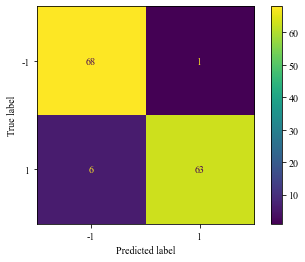

In [785]:
acc_train = accuracy(check)
print(acc_train)
cm = make_confusion_matrix(check)
i = make_indicator(cm)
F1_train = i['F1']
display(i)

####Val Accuracy

In [786]:
check = test(network, x_val, y_val)
print(len(check))
check[:5]

<<  Test Start  >>
 ------------------------------
 ------------------------------
<<  Test End  >>

34


[(0.005618572235107422, array([-1.13943594])),
 (0.5380721092224121, array([-0.93664553])),
 (-1.298841953277588, array([-0.6531305])),
 (-1.094740390777588, array([-0.94640085])),
 (1.827256679534912, array([0.2109153]))]

0.7058823529411765


{'TPR': 0.8235294117647058,
 'TNR': 0.5882352941176471,
 'PPV': 0.6666666666666666,
 'NPV': 0.7692307692307693,
 'FNR': 0.17647058823529413,
 'FPR': 0.4117647058823529,
 'FDR': 0.3333333333333333,
 'FOR': 0.23076923076923078,
 'F1': 0.7368421052631579}

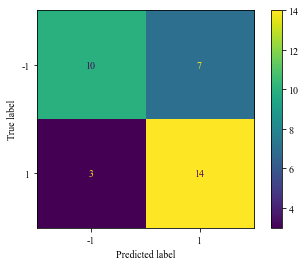

In [787]:
acc_val = accuracy(check)
print(acc_val)
cm = make_confusion_matrix(check)
i = make_indicator(cm)
display(i)

####Test Accuracy

In [788]:
check = test(network, x_test, y_test)
print(len(check))
check[:5]

<<  Test Start  >>
 ------------------------------
 ------------------------------
<<  Test End  >>

74


[(-2.000990390777588, array([0.53628255])),
 (0.01463460922241211, array([-1.66433411])),
 (-1.075209140777588, array([0.40262546])),
 (0.07713460922241211, array([0.40532561])),
 (-1.188490390777588, array([-0.70173308]))]

0.581081081081081


{'TPR': 0.8108108108108109,
 'TNR': 0.35135135135135137,
 'PPV': 0.5555555555555556,
 'NPV': 0.65,
 'FNR': 0.1891891891891892,
 'FPR': 0.6486486486486487,
 'FDR': 0.4444444444444444,
 'FOR': 0.35,
 'F1': 0.6593406593406593}

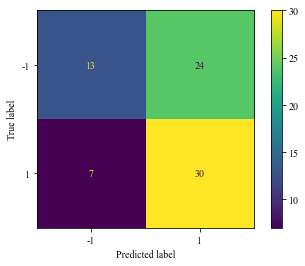

In [789]:
acc_test = accuracy(check)
print(acc_test)
cm = make_confusion_matrix(check)
i = make_indicator(cm)
F1_test = i['F1']
display(i)

#### X:資料量 Y:Hidden node數量

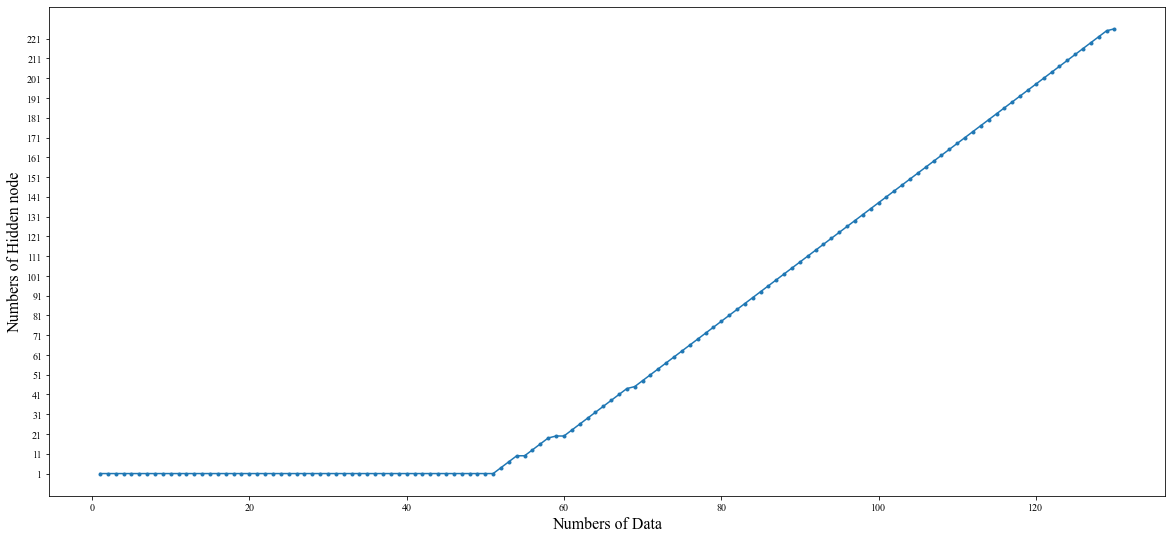

In [790]:
%matplotlib inline
import matplotlib.pyplot as plt


#

x = list(num_hiddennodes.keys())
y = list(num_hiddennodes.values())
fig, ax = plt.subplots(1,1,figsize=(20,9))
ax.plot(x,y,'-', marker='.')
plt.rcParams["font.family"] = "Times New Roman" 
plt.yticks(range(min(num_hiddennodes.values()), max(num_hiddennodes.values())+1,10))
plt.xlabel("Numbers of Data", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
# ax.text(0.95, 0.01, f'Train Accuracy : {acc_train:3f}, F1 score : {F1_train:3f}\nTest Accuracy : {acc_test:3f}, F1 score : {F1_test:3f}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=15)
plt.show()

In [791]:
temp = num_hiddennodes

In [803]:
demand_x = list(num_hiddennodes.keys())[50:70]
demand_y = list(temp.values())[50:70]

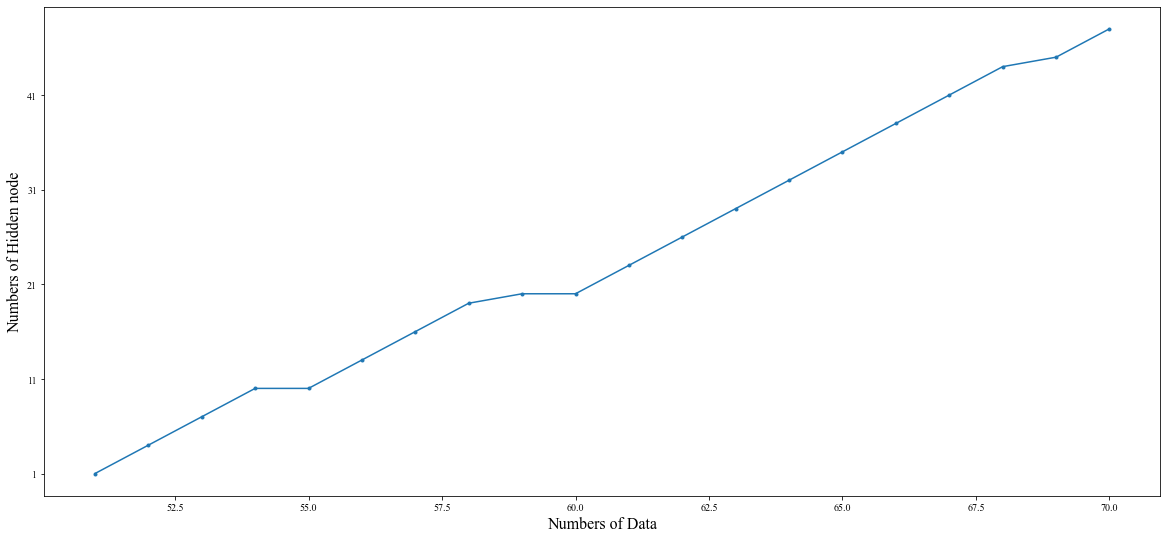

In [804]:
%matplotlib inline
import matplotlib.pyplot as plt


#

x = demand_x
y = demand_y
fig, ax = plt.subplots(1,1,figsize=(20,9))
ax.plot(x,y,'-', marker='.')
plt.rcParams["font.family"] = "Times New Roman" 
plt.yticks(range(min(demand_y), max(demand_y)+1,10))
plt.xlabel("Numbers of Data", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
# ax.text(0.95, 0.01, f'Train Accuracy : {acc_train:3f}, F1 score : {F1_train:3f}\nTest Accuracy : {acc_test:3f}, F1 score : {F1_test:3f}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=15)
plt.show()

####X:資料量 Y:被修剪的node數量

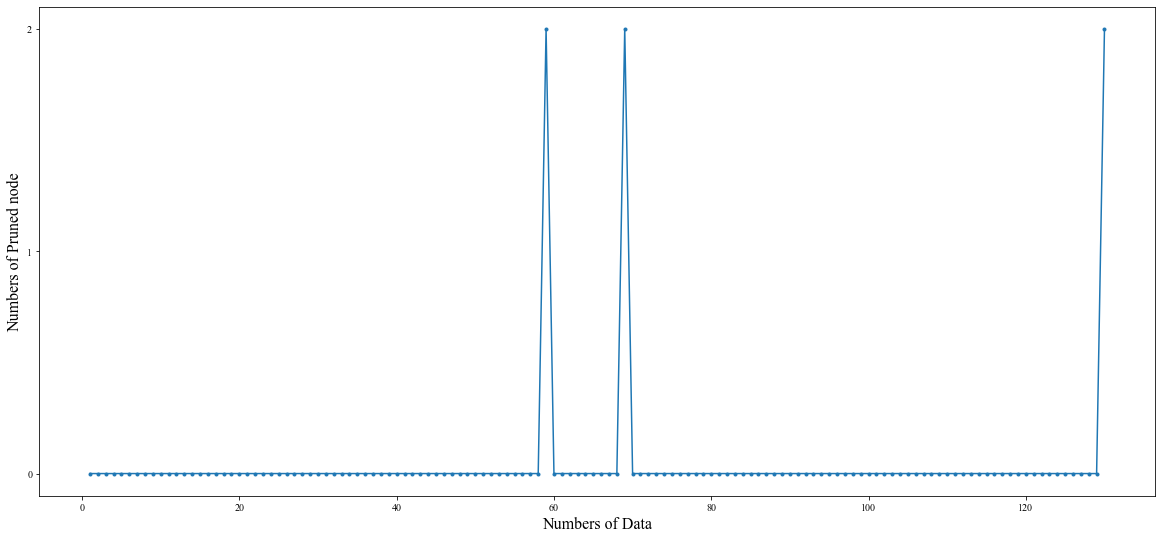

In [794]:
%matplotlib inline
import matplotlib.pyplot as plt


x = list(reorganizing_sucess.keys())
y = list(reorganizing_sucess.values())
fig, ax = plt.subplots(1,1,figsize=(20,9))
ax.plot(x,y,'-', marker='.')
plt.rcParams["font.family"] = "Times New Roman" 
plt.xlabel("Numbers of Data", fontsize=16) #x軸標題
plt.ylabel("Numbers of Pruned node", fontsize=16) #y軸標題
plt.yticks(range(min(reorganizing_sucess.values()), max(reorganizing_sucess.values())+1,1)) 
# ax.text(0.5, 0.9, f'Train Accuracy : {acc_train}, F1 score : {F1_train}\nTest Accuracy : {acc_test}, F1 score : {F1_test}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=15)
plt.show()

####X:時間(s) Y:Hidden node數量

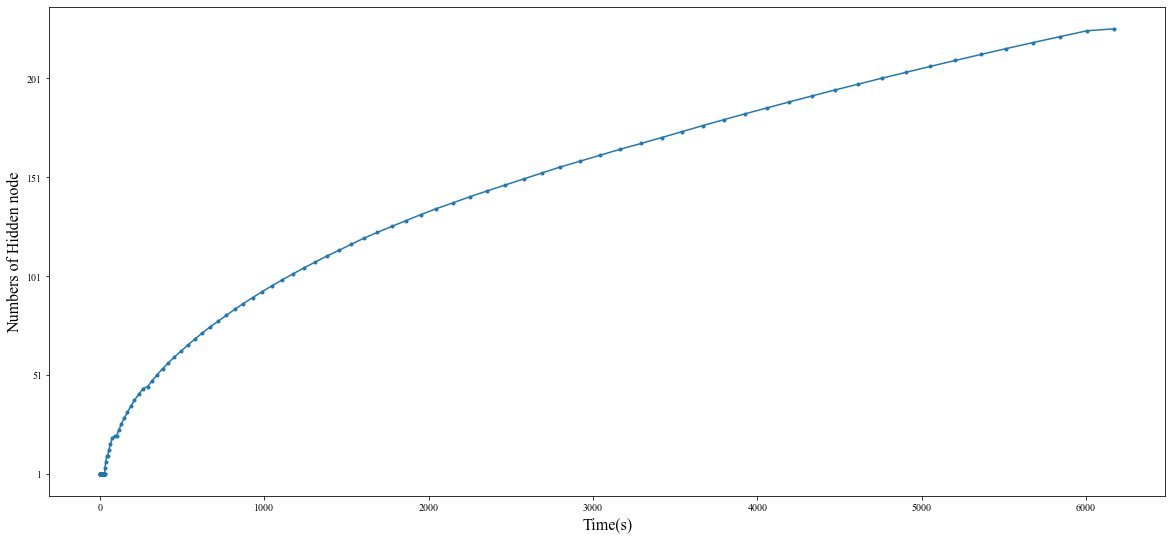

In [795]:
%matplotlib inline
import matplotlib.pyplot as plt

x = timestamp
y = list(num_hiddennodes.values())
fig, ax = plt.subplots(1,1,figsize=(20,9))
ax.plot(x,y,'-', marker='.')
plt.rcParams["font.family"] = "Times New Roman" 
plt.xlabel("Time(s)", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
plt.yticks(range(min(num_hiddennodes.values()), max(num_hiddennodes.values())+1,50))
# ax.text(0.95, 0.01, f'Train Accuracy : {acc_train}, F1 score : {F1_train}\nTest Accuracy : {acc_test}, F1 score : {F1_test}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=15)
plt.show()

In [ ]:
temp = num_hiddennodes

In [816]:
demand_x = list(timestamp)[50:70]
demand_y = list(num_hiddennodes.values())[50:70]

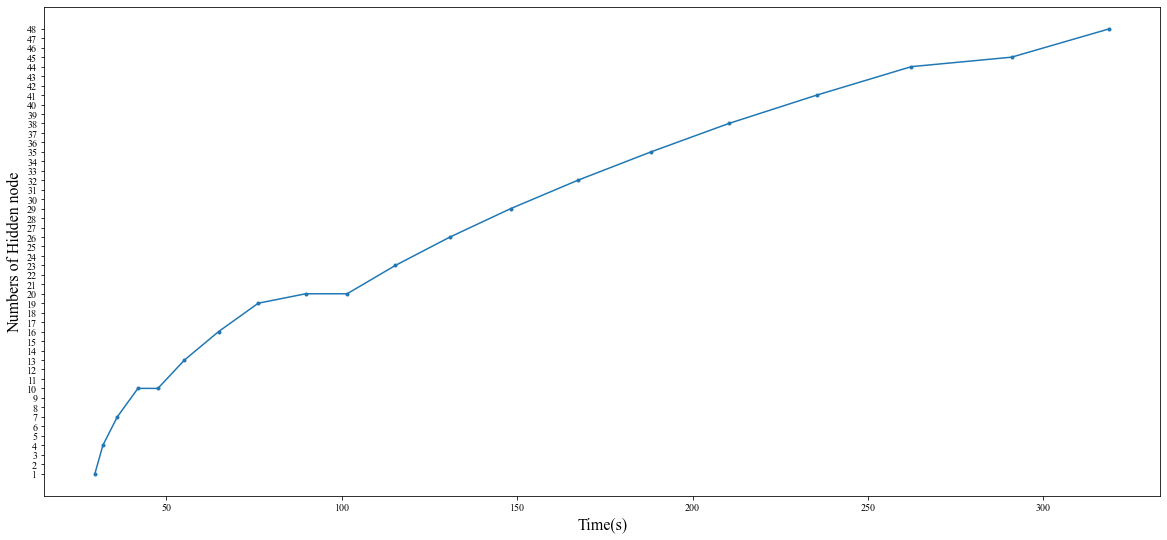

In [819]:
%matplotlib inline
import matplotlib.pyplot as plt

x = demand_x
y = demand_y
fig, ax = plt.subplots(1,1,figsize=(20,9))
ax.plot(x,y,'-', marker='.')
plt.rcParams["font.family"] = "Times New Roman" 
plt.xlabel("Time(s)", fontsize=16) #x軸標題
plt.ylabel("Numbers of Hidden node", fontsize=16) #y軸標題
plt.yticks(range(min(y), max(y)+1,1))
# ax.text(0.95, 0.01, f'Train Accuracy : {acc_train}, F1 score : {F1_train}\nTest Accuracy : {acc_test}, F1 score : {F1_test}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color='black', fontsize=15)
plt.show()

####ROC Curve

In [797]:
#y_pred, y_real, y_label = check_spliting(check)

#Softmax
# y_pred_exp = [np.exp(i) for i in y_pred]

# sum_y_pred_exp = sum(y_pred_exp)

# y_pred_softmax = np.array([(i/sum_y_pred_exp) for i in y_pred_exp])
# y_pred_softmax

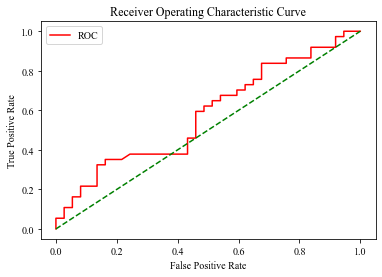

In [798]:
y_pred, y_real, y_label = check_spliting(check)

y_pred_nml = [((i - min(y_pred))/(max(y_pred) - min(y_pred))) for i in y_pred]
#(y_pred_nml)

from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.rcParams["font.family"] = "Times New Roman" 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

fper, tper, thresholds = roc_curve(y_label, y_pred_nml, pos_label = -1)
plot_roc_curve(fper, tper)